# constants

In [148]:
__NB_DIMS__ = 2

LEGS = [0, 1, 2, 5, 6, 7]
LEGS = [0, 1, 2] #, 5, 6, 7] # since we do not care about the other side
CAMERA_OF_INTEREST = 1
NB_OF_AXIS = 2
NB_TRACKED_POINTS = 5 # per leg, igoring the rest for now
NB_CAMERAS = 7
NB_RECORDED_DIMESIONS = 2

FRAMES_PER_SECOND = 100
NYQUIST_FREQUENCY_OF_MEASUREMENTS = FRAMES_PER_SECOND / 2

FLY = "181220_Rpr_R57C10_GC6s_tdTom"

POSE_DATA_PATH = "/ramdya-nas/SVB/{fly_id}/001_coronal/behData/images_renamed/pose_result__mnt_NAS_SVB_181220_Rpr_R57C10_GC6s_tdTom_001_coronal_behData_images_renamed.pkl".format(fly_id=FLY)
POSE_FRAME_PATH = "/ramdya-nas/SVB/{fly_id}/001_coronal/behData/images_renamed/camera_{{camera_id}}_img_{{frame_id:06d}}.jpg".format(fly_id=FLY)

SEQUENCE_GIF_PATH = "/home/samuel/Videos/{fly_id}/sequence_gif_{{begin_frame}}-{{end_frame}}.mp4".format(fly_id=FLY)

# imports & functions

## imports

In [161]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pandas as pd

from sklearn.metrics import mean_squared_error
from tqdm import tqdm, trange
import pathlib
import logging
import datetime
from datetime import date
import os
import uuid
from glob import glob
import shutil
import pickle
import skimage
from functools import reduce
from skimage import io
import matplotlib.pyplot as plt
import seaborn as sns

# for creating the gifs
import PIL
import imageio
import cv2
from IPython import display

%matplotlib inline

from importlib import reload
import inspect
from itertools import groupby
import sys
sys.path.append('/home/samuel/')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from drosophpose.GUI import skeleton

from som_vae import somvae_model
from som_vae.utils import *

## general helpers

In [94]:
def extract_args(config, function):
    return {k:config[k] for k in inspect.getfullargspec(function).args if k in config}

In [95]:
def chunks(l, n):
    """Yield successive n-sized chunks from l. Use it to create batches."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [162]:
def convert_bytes(num):
    """
    this function will convert bytes to MB.... GB... etc
    """
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if num < 1024.0:
            return "%3.1f %s" % (num, x)
        num /= 1024.0


def file_size(file_path):
    """
    this function will return the file size
    """
    if os.path.isfile(file_path):
        file_info = os.stat(file_path)
        return convert_bytes(file_info.st_size)

In [96]:
def fix_layout(width:int=95):
    from IPython.core.display import display, HTML
    display(HTML("<style>.container { width:" + str(width) + "% !important; }</style>"))
    
fix_layout()

## data loading helpers

In [97]:
def load_data(path=POSE_DATA_PATH):
    with open(POSE_DATA_PATH, 'rb') as f:
        pose_data_raw = pickle.load(f)
        return pose_data_raw['points2d']

In [98]:
def _check_shape_(joint_positions):
    """ should be (7, <nb frames>, 38, 2)
    7 for the images, some should be 0 because it didn't record the images for these points
    1000 for the nb of frames
    38 for the features (some for the legs ...) check skeleton.py in semigh's code
    2 for the pose dimensions
    """
    s = joint_positions.shape
    
    if s[0] != NB_CAMERAS or s[2] != len(skeleton.tracked_points) or s[3] != NB_RECORDED_DIMESIONS:
        raise ValueError(f"shape of pose data is wrong, it's {joint_positions.shape}")
        
    return joint_positions 

def _crude_value_check_(joint_positions):
    if np.sum(joint_positions == 0) == np.product(joint_positions.shape):
        raise ValueError('not every value should be zero')
        
    return joint_positions

def _simple_checks_(data):
    return reduce(lambda acc, el: el(acc), [_check_shape_, _crude_value_check_], data)

In [99]:
def _get_camera_of_interest_(joint_positions, camera_idx=CAMERA_OF_INTEREST):
    return joint_positions[CAMERA_OF_INTEREST]

def _get_visible_legs_(joint_positions, camera_idx=CAMERA_OF_INTEREST):
    idx_visible_joints = [skeleton.camera_see_joint(CAMERA_OF_INTEREST, j) for j in range(len(skeleton.tracked_points))]
    return joint_positions[:, idx_visible_joints, :]

In [100]:
def get_data(path=POSE_DATA_PATH):
    return reduce(lambda acc, el: el(acc), [load_data, _simple_checks_, _get_camera_of_interest_, _get_visible_legs_], path)

In [101]:
def add_third_dimension(joint_positions):
    # just add a z-axis
    # look up np.pad...
    # assumes that the positional data is in the last axis
    paddings = [[0, 0] for i in joint_positions.shape]
    paddings[-1][1] = 1

    return np.pad(joint_positions, paddings, mode='constant', constant_values=0)

## plotting helpers

In [102]:
def _get_feature_name_(tracking_id):
    return str(skeleton.tracked_points[tracking_id])[len('Tracked.'):]

def _get_feature_id_(leg_id, tracking_point_id):
    if leg_id < 3:
        return leg_id * 5 + tracking_point_id
    else:
        return (leg_id - 5) * 5 + tracking_point_id + 19
    
def _get_leg_name_(leg_id):
    __LEG_NAMES__ = ['foreleg', 'middle leg', 'hind leg']
    return __LEG_NAMES__[leg_id]

def ploting_frames(joint_positions):
    for leg in LEGS:
        fig, axs = plt.subplots(1, NB_OF_AXIS, sharex=True, figsize=(20, 10))
        for tracked_point in range(NB_TRACKED_POINTS):
            for axis in range(NB_OF_AXIS):
                cur_ax = axs[axis]
                cur_ax.plot(joint_positions[:, _get_feature_id_(leg, tracked_point),  axis], label = f"{_get_feature_name_(tracked_point)}_{('x' if axis == 0 else 'y')}")
                if axis == 0:
                    cur_ax.set_ylabel('x pos')
                else:
                    cur_ax.set_ylabel('y pos')
                cur_ax.legend(loc='upper right')
                cur_ax.set_xlabel('frame')

        #plt.xlabel('frame')
        #plt.legend(loc='lower right')
        plt.suptitle(_get_leg_name_(leg))

In [103]:
def plot_comparing_joint_position_with_reconstructed(real_joint_positions, reconstructed_joint_positions, validation_cut_off=None):
    for leg in LEGS:
        fig, axs = plt.subplots(1, NB_OF_AXIS * 2, sharex=True, figsize=(25, 10))
        for axis in range(NB_OF_AXIS):
            cur_ax = axs[axis * 2]
            rec_ax = axs[axis * 2 + 1]
            
            if validation_cut_off is not None:
                for a in [cur_ax, rec_ax]:
                    a.axvline(validation_cut_off, label='validation cut off', linestyle='--')
                    
            for tracked_point in range(NB_TRACKED_POINTS):
                cur_ax.plot(joint_positions[:, _get_feature_id_(leg, tracked_point),  axis], label = f"{_get_feature_name_(tracked_point)}_{('x' if axis == 0 else 'y')}")
                rec_ax.plot(reconstructed_joint_positions[:, _get_feature_id_(leg, tracked_point),  axis], label = f"{_get_feature_name_(tracked_point)}_{('x' if axis == 0 else 'y')}")
                cur_ax.get_shared_y_axes().join(cur_ax, rec_ax)
                if axis == 0:
                    cur_ax.set_ylabel('x pos')
                    rec_ax.set_ylabel('x pos')
                else:
                    cur_ax.set_ylabel('y pos')
                    rec_ax.set_ylabel('y pos')
                cur_ax.legend(loc='upper right')
                cur_ax.set_xlabel('frame')
                rec_ax.legend(loc='upper right')
                rec_ax.set_xlabel('frame')
                cur_ax.set_title('original data')
                rec_ax.set_title('reconstructed data')
                

                
        #plt.xlabel('frame')
        #plt.legend(loc='lower right')
        plt.suptitle(_get_leg_name_(leg))

In [104]:
def plot_losses(losses, legend=None):
    plt.figure(figsize=(15, 8))
    if legend is None:
        legend = ['train', 'test', 'test_recon'] 
    plt.figure()
    for l in losses:
        plt.plot(l)

    plt.legend(legend)
    plt.xlabel('epoch')
    plt.title('loss')

In [105]:
def plot_latent_frame_distribution(latent_assignments, nb_bins):
    plt.figure()
    plt.hist(latent_assignments, bins=nb_bins)
    plt.title('distribution of latent-space-assignments')
    plt.xlabel('latent-space')
    plt.ylabel('nb of frames in latent-space')

In [106]:
def plot_cluster_assignment_over_time(cluster_assignments):
    plt.figure()
    plt.plot(cluster_assignments)
    plt.title("cluster assignments over time")
    plt.ylabel("index of SOM-embeddings")
    plt.xlabel("frame")

## video and gif helpers

In [160]:
import io
import base64
from IPython.display import HTML

def display_video(path):
    video = io.open(path, 'r+b').read()
    encoded = base64.b64encode(video)
    return HTML(data='''<video alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))

In [107]:
import matplotlib.colors as mc
import colorsys


def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    
    Taken from here: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib#answer-49601444

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def lighten_int_colors(cs, amount=0.5):
    return [(np.array(lighten_color(np.array(c) / 255, amount=amount)) * 255).astype(np.int).tolist() for c in cs]

# taken from https://github.com/NeLy-EPFL/drosoph3D/blob/master/GUI/plot_util.py
def plot_drosophila_2d(pts=None, draw_joints=None, img=None, colors=None, thickness=None,
                       draw_limbs=None, circle_color=None):
    if colors is None:
        colors = skeleton.colors
    if thickness is None:
        thickness = [2] * 10
    if draw_joints is None:
        draw_joints = np.arange(skeleton.num_joints)
    if draw_limbs is None:
        draw_limbs = np.arange(skeleton.num_limbs)
    for joint_id in range(pts.shape[0]):
        limb_id = skeleton.get_limb_id(joint_id)
        if (pts[joint_id, 0] == 0 and pts[joint_id, 1] == 0) or limb_id not in draw_limbs or joint_id not in draw_joints:
            continue

        color = colors[limb_id]
        r = 5 if joint_id != skeleton.num_joints - 1 and joint_id != ((skeleton.num_joints // 2) - 1) else 8
        cv2.circle(img, (pts[joint_id, 0], pts[joint_id, 1]), r, color, -1)

        # TODO replace this with skeleton.bones
        if (not skeleton.is_tarsus_tip(joint_id)) and (not skeleton.is_antenna(
                joint_id)) and (joint_id != skeleton.num_joints - 1) and (
                joint_id != (skeleton.num_joints // 2 - 1)) and (not (
                pts[joint_id + 1, 0] == 0 and pts[joint_id + 1, 1] == 0)):
            cv2.line(img, (pts[joint_id][0], pts[joint_id][1]), (pts[joint_id + 1][0], pts[joint_id + 1][1]),
                     color=color,
                     thickness=thickness[limb_id])

    if circle_color is not None:
        img = cv2.circle(img=img, center=(img.shape[1]-20, 20), radius=10, color=circle_color, thickness=-1)

    return img

In [108]:
def gif_with_x(x, embeddings, file_path=None):
    """Creates a video (saved as a gif) with the embedding overlay, displayed as an int.
    
    Args:
        embeddings: [<embeddings_id>]    
            assumed to be in sequence with `get_frame_path` function.
        file_path: <str>, default: SEQUENCE_GIF_PATH  
            file path used to get 
    Returns:
        <str>                            the file path under which the gif was saved
    """
    if file_path is None:
        gif_file_path = SEQUENCE_GIF_PATH.format(begin_frame="full-video", end_frame="with-embeddings")
    else:
        gif_file_path = file_path

    pathlib.Path(gif_file_path).parent.mkdir(parents=True, exist_ok=True)
    
    with imageio.get_writer(gif_file_path, mode='I') as writer:
        filenames =  [(get_frame_path(i), emb_id) for i, emb_id in enumerate(embeddings)]
        last = -1
        for i, (filename, emb_id) in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
                
            image = cv2.imread(filename)  
            
            
            # adding 
            image = plot_drosophila_2d(x[i].astype(np.int), img=image)
                
            cv2.line(image, (0, emb_id), (10, emb_id), (0, 255, 0), 2)
            image = cv2.putText(img=np.copy(image), text=f"{emb_id:0>3}", org=(0, image.shape[0] // 2),fontFace=2, fontScale=3, color=(255, 255, 255), thickness=2)
            image = cv2.putText(img=np.copy(image), text=f"fr: {i:0>4}", org=(0, (image.shape[0] // 2) + 24),fontFace=1, fontScale=2, color=(255, 255, 255), thickness=2)
            writer.append_data(image)
            writer.append_data(image)

        #image = imageio.imread(filename)
        #writer.append_data(image)
    
    return gif_file_path


def gif_with_xs(xs, embeddings, file_path=None):
    """Creates a video (saved as a gif) with the embedding overlay, displayed as an int.
    
    Args:
        xs: [<pos data: [frames, limb, dimensions]>]
            will plot all of them, the colors get lighter
        embeddings: [<embeddings_id>]    
            assumed to be in sequence with `get_frame_path` function.
        file_path: <str>, default: SEQUENCE_GIF_PATH  
            file path used to get 
    Returns:
        <str>                            the file path under which the gif was saved
    """
    if file_path is None:
        # arguments for the path are missused, just FYI
        gif_file_path = SEQUENCE_GIF_PATH.format(begin_frame="full-video-x_x-hat", end_frame="with-embeddings")
    else:
        gif_file_path = file_path

    pathlib.Path(gif_file_path).parent.mkdir(parents=True, exist_ok=True)
    
    with imageio.get_writer(gif_file_path, mode='I') as writer:
        filenames =  [(get_frame_path(i), emb_id) for i, emb_id in enumerate(embeddings)]
        last = -1
        for i, (filename, emb_id) in enumerate(filenames):
            frame = 2*(i**0.5)
            if round(frame) > round(last):
                last = frame
            else:
                continue
                
            image = cv2.imread(filename)  
            
            
            # adding 
            for x_i, x in enumerate(xs):
                image = plot_drosophila_2d(x[i].astype(np.int), img=image, colors=lighten_int_colors(skeleton.colors, amount=np.linspace(0, 0.5, len(xs))[x_i]))
                
            cv2.line(image, (0, emb_id), (10, emb_id), (0, 255, 0), 2)
            image = cv2.putText(img=np.copy(image), text=f"{emb_id:0>3}", org=(0, image.shape[0] // 2),fontFace=2, fontScale=3, color=(255, 255, 255), thickness=2)
            image = cv2.putText(img=np.copy(image), text=f"fr: {i:0>4}", org=(0, (image.shape[0] // 2) + 24),fontFace=1, fontScale=2, color=(255, 255, 255), thickness=2)
            writer.append_data(image)
            writer.append_data(image)

        #image = imageio.imread(filename)
        #writer.append_data(image)
    
    return gif_file_path

# data loading

In [109]:
if __NB_DIMS__ == 3:
    joint_positions = add_third_dimension(get_data())
else:
    joint_positions = add_third_dimension(get_data())
    

NB_FRAMES = joint_positions.shape[1]

In [110]:
for leg in LEGS:
    print("{0:.3}% of the data for leg {1} is 0".format((joint_positions[:, leg:leg+5, :2] == 0).mean(), leg))

0.0% of the data for leg 0 is 0
0.0% of the data for leg 1 is 0
0.0% of the data for leg 2 is 0


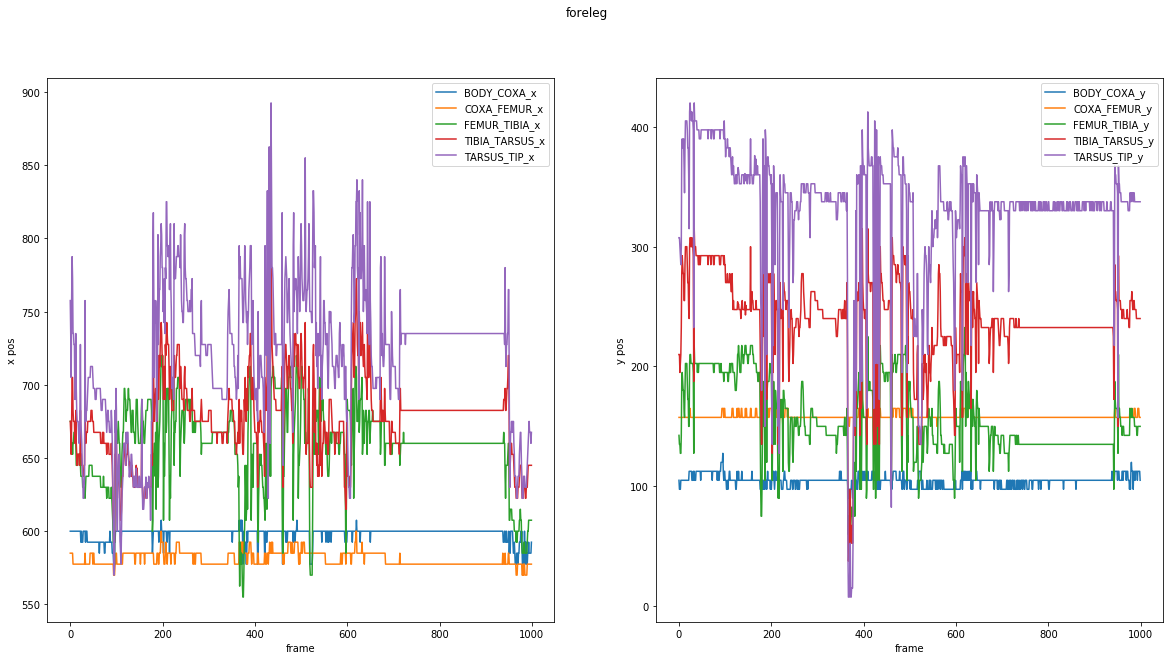

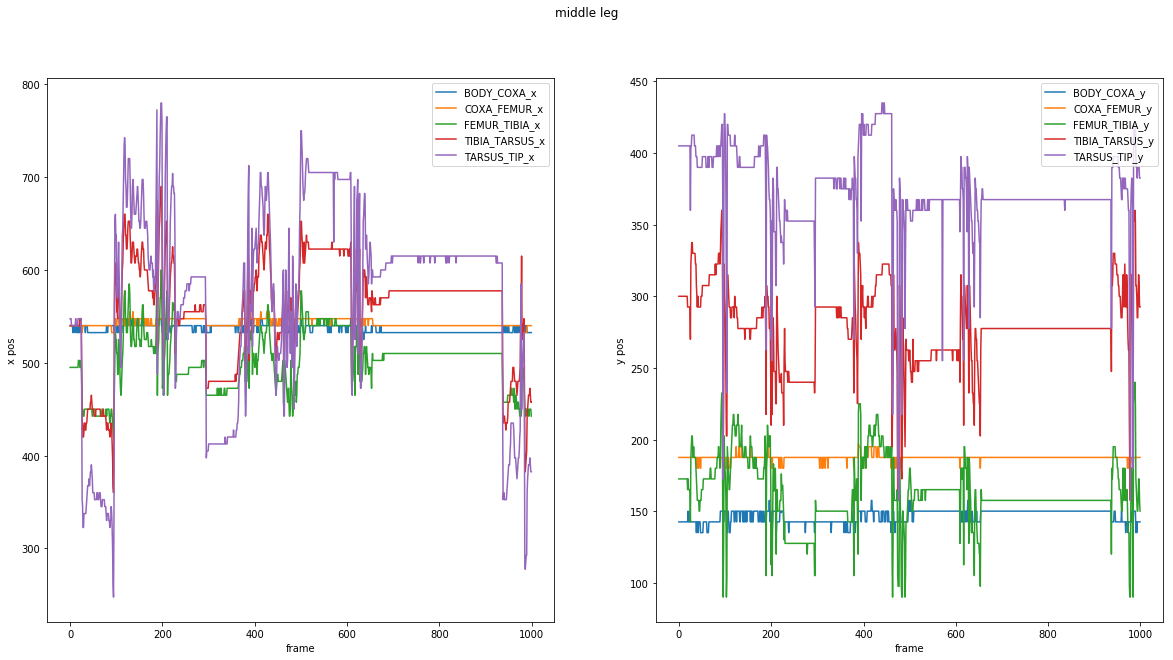

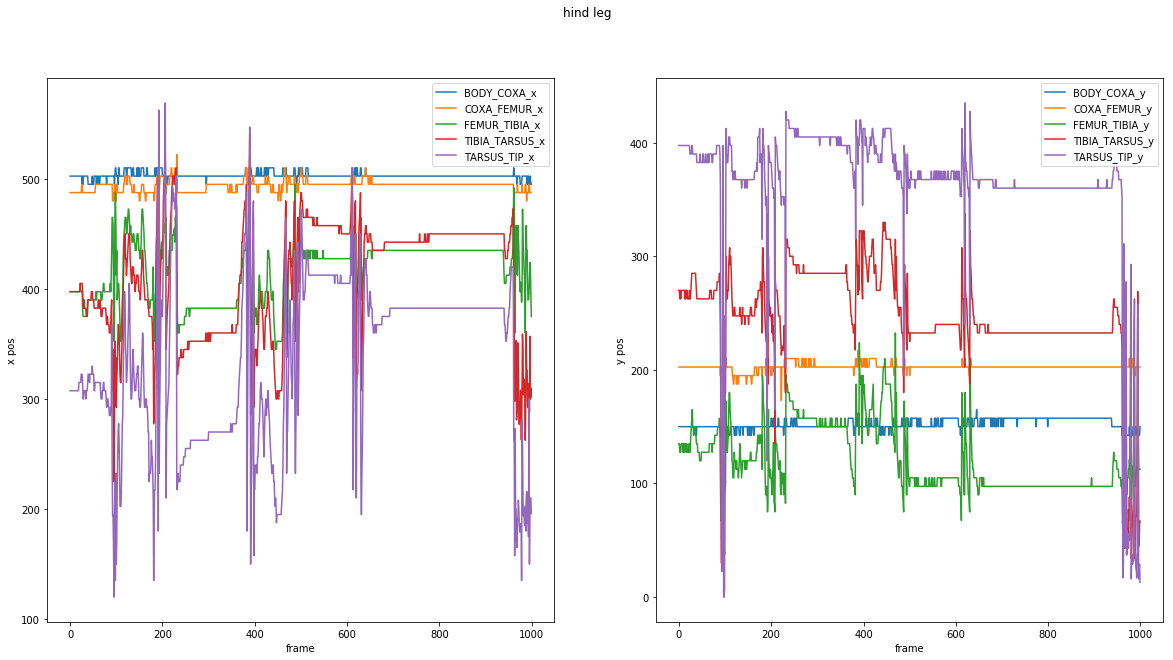

In [111]:
ploting_frames(joint_positions)

In [112]:
def normalize(joint_positions, using_median=True, to_probability_distr=False):
    # alternatives could be to use only the median of the first joint -> data is then fixed to top (is that differnt to now?)
    if using_median:
        applied = np.median(joint_positions.reshape(-1, 3), axis=0)
        return joint_positions - applied, applied
    elif to_probability_distr:
        return
    else:
        raise NotImplementedError

In [113]:
def normalize_ts(time_series, ax=0):
    # for shape (frame,feat)
    eps = 0.0001
    print("shapes:", np.shape(np.transpose(time_series)), np.shape(np.mean(np.transpose(time_series), axis=ax)))
#     n_time_series = (np.transpose(time_series) - np.mean(np.transpose(time_series), axis=ax))/(np.std(np.transpose(time_series), axis=ax) + eps)
    norm = np.sum(np.transpose(time_series), axis=ax); norm = np.transpose(norm) #shape = 1,frames
    n_time_series = np.transpose(time_series) / np.sum(np.transpose(time_series), axis=ax)
    n_time_series = np.transpose(n_time_series)
#     n_time_series = np.zeros(shape=np.shape(time_series))
#     for i in range(np.shape(time_series)[1]):
#         n_time_series[:,i] = (time_series[:,i] - np.mean(time_series[:,i])) / (np.std(time_series[:,i]) + eps)
    return n_time_series, norm


def normalize_pose(points3d, median3d=False):
    # normalize experiment
    if median3d:
        points3d -= np.median(points3d.reshape(-1, 3), axis=0)
    else:
        for i in range(np.shape(points3d)[1]): #frames
            for j in range(np.shape(points3d)[2]): #xyz
                points3d[:,i,j] = normalize_ts(points3d[:,i,j]) 
    return points3d

In [114]:
joint_positions_raw = joint_positions.copy()
joint_positions, joint_norm_factor = normalize(joint_positions)

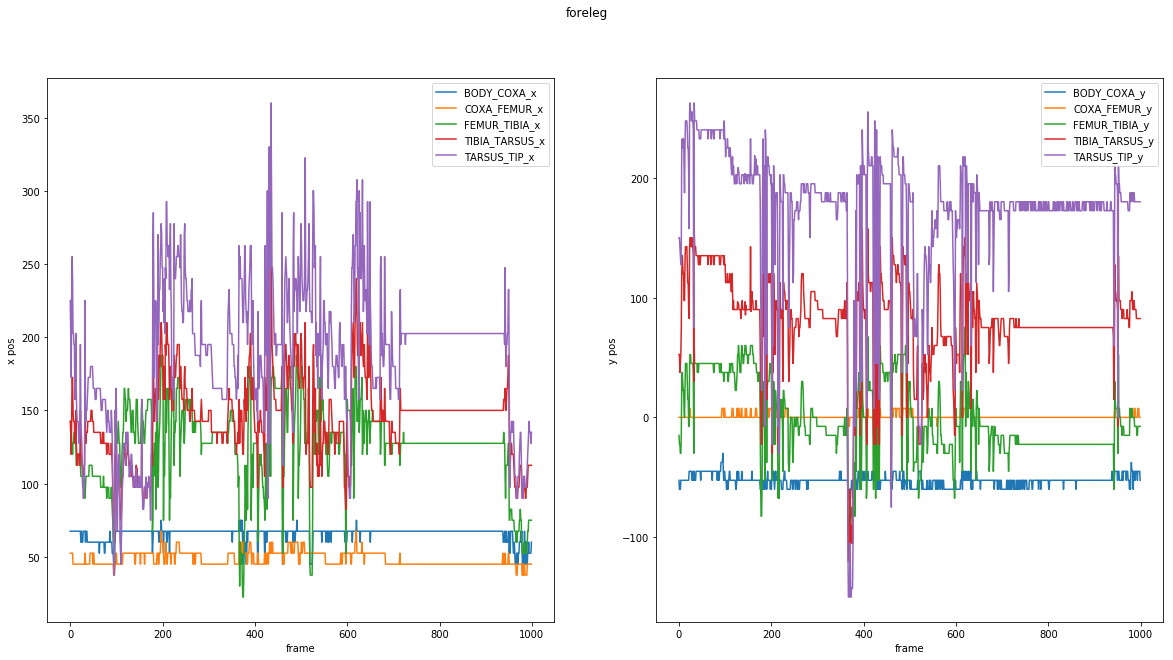

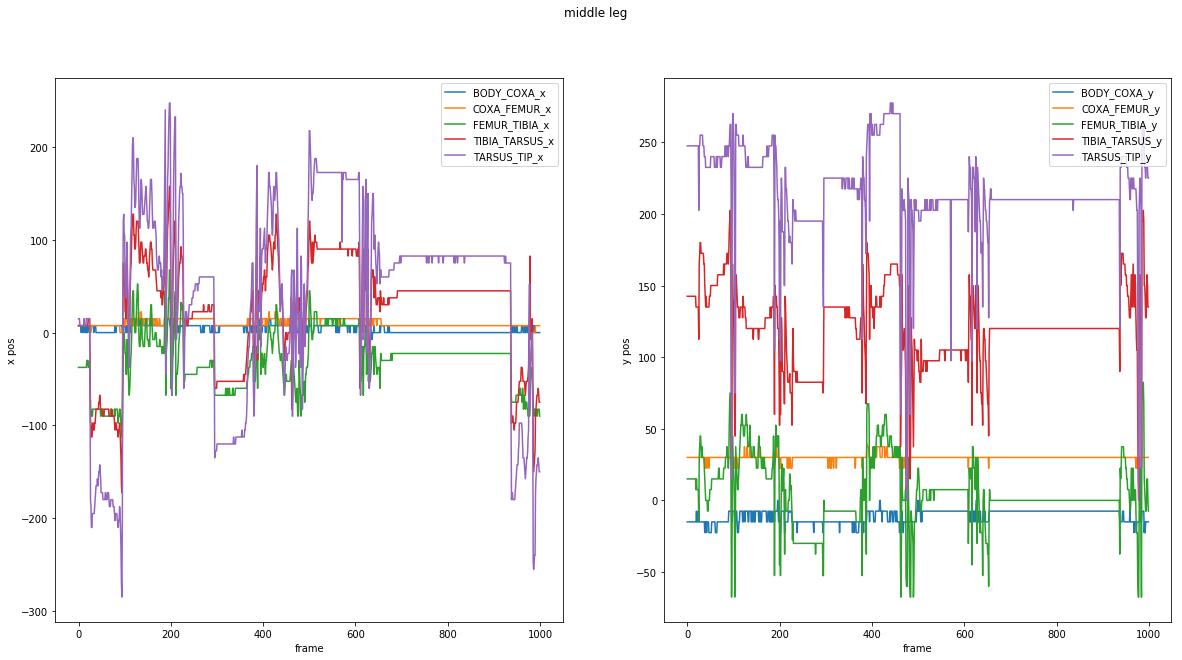

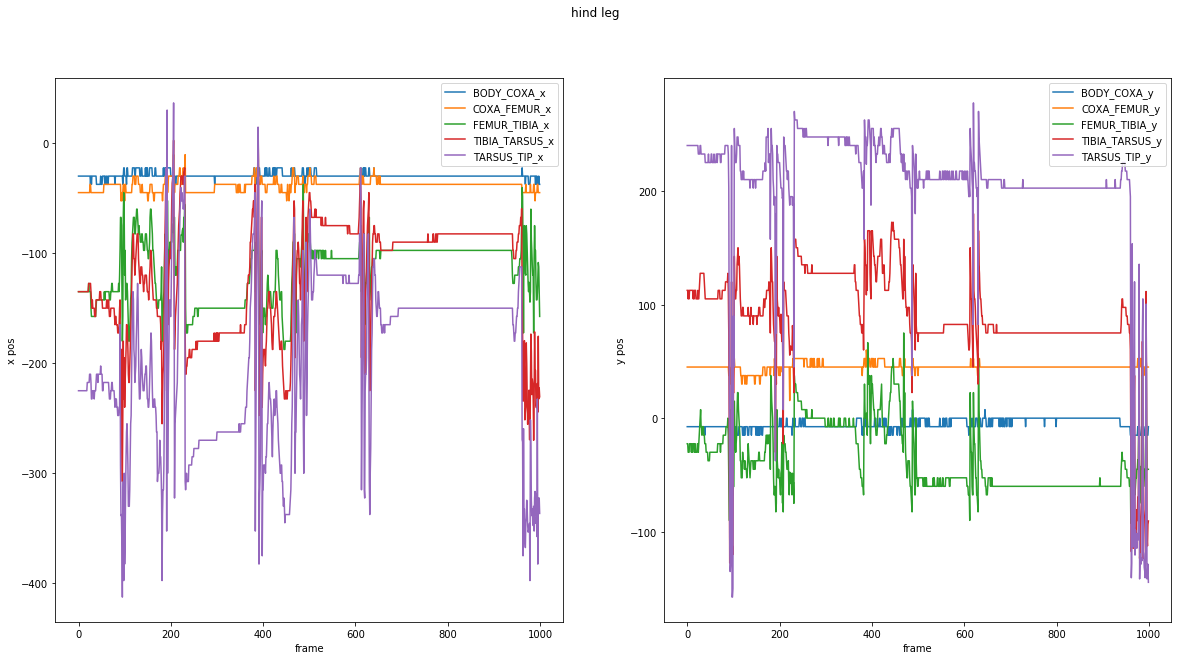

In [115]:
ploting_frames(joint_positions)

# SOM-VAE model

## constant

In [116]:
__TF_DEFAULT_SESSION_CONFIG__ = tf.ConfigProto()
__TF_DEFAULT_SESSION_CONFIG__.gpu_options.allow_growth = True 
__TF_DEFAULT_SESSION_CONFIG__.gpu_options.polling_inactive_delay_msecs = 10

## functions

In [117]:
def get_data_generator(data_train, labels_train, data_val, labels_val, time_series):
    """Creates a data generator for the training.
    
    Args:
        time_series (bool): Indicates whether or not we want interpolated MNIST time series or just
            normal MNIST batches.
    
    Returns:
        generator: Data generator for the batches."""

    def batch_generator(mode="train", batch_size=100):
        """Generator for the data batches.
        
        Args:
            mode (str): Mode in ['train', 'val'] that decides which data set the generator
                samples from (default: 'train').
            batch_size (int): The size of the batches (default: 100).
            
        Yields:
            np.array: Data batch.
        """
        assert mode in ["train", "val"], "The mode should be in {train, val}."
        if mode=="train":
            images = data_train.copy()
            labels = labels_train.copy()
        elif mode=="val":
            images = data_val.copy()
            labels = labels_val.copy()
        
        while True:
            indices = np.random.permutation(np.arange(len(images)))
            images = images[indices]
            labels = labels[indices]

            if time_series:
                for i, image in enumerate(images):
                    start_image = image
                    end_image = images[np.random.choice(np.where(labels == (labels[i] + 1) % 10)[0])]
                    interpolation = interpolate_arrays(start_image, end_image, batch_size)
                    yield interpolation + np.random.normal(scale=0.01, size=interpolation.shape)
            else:
                for i in range(len(images)//batch_size):
                    yield images[i*batch_size:(i+1)*batch_size]

    return batch_generator

In [118]:
def train_model(model, x, lr_val, num_epochs, patience, batch_size, logdir,
        modelpath, learning_rate, interactive, generator):
    """Trains the SOM-VAE model.
    
    Args:
        model (SOM-VAE): SOM-VAE model to train.
        x (tf.Tensor): Input tensor or placeholder.
        lr_val (tf.Tensor): Placeholder for the learning rate value.
        num_epochs (int): Number of epochs to train.
        patience (int): Patience parameter for the early stopping.
        batch_size (int): Batch size for the training generator.
        logdir (path): Directory for saving the logs.
        modelpath (path): Path for saving the model checkpoints.
        learning_rate (float): Learning rate for the optimization.
        interactive (bool): Indicator if we want to have an interactive
            progress bar for training.
        generator (generator): Generator for the data batches.
    """
    train_gen = generator("train", batch_size)
    val_gen = generator("val", batch_size)

    num_batches = len(data_train)//batch_size

    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    summaries = tf.summary.merge_all()
    
    session_config = tf.ConfigProto()
    session_config.gpu_options.allow_growth = True  
    session_config.gpu_options.polling_inactive_delay_msecs = 10
    
    with tf.Session(config=session_config) as sess:
        sess.run(tf.global_variables_initializer())
        patience_count = 0
        train_losses = []
        test_losses = []
        test_losses_reconstrution = []
        train_writer = tf.summary.FileWriter(logdir+"/train", sess.graph)
        test_writer = tf.summary.FileWriter(logdir+"/test", sess.graph)
        print("Training...")
        train_step_SOMVAE, train_step_prob = model.optimize
        try:
            if interactive:
                pbar = tqdm(total=num_epochs*(num_batches)) 
            for epoch in range(num_epochs):
                batch_val = next(val_gen)
                test_loss, summary, test_loss_reconstruction = sess.run([model.loss, summaries, model.loss_reconstruction], feed_dict={x: batch_val})
                test_losses.append(test_loss)
                test_losses_reconstrution.append(test_loss_reconstruction)
                test_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                if test_losses[-1] == min(test_losses):
                    saver.save(sess, modelpath, global_step=epoch)
                    patience_count = 0
                else:
                    patience_count += 1
                if patience_count >= patience:
                    break
                for i in range(num_batches):
                    batch_data = next(train_gen)
                    if i%100 == 0:
                        train_loss, summary = sess.run([model.loss, summaries], feed_dict={x: batch_data})
                        train_writer.add_summary(summary, tf.train.global_step(sess, model.global_step))
                        train_losses += [train_loss]
                    train_step_SOMVAE.run(feed_dict={x: batch_data, lr_val:learning_rate})
                    train_step_prob.run(feed_dict={x: batch_data, lr_val:learning_rate*100})
                    if interactive:
                        pbar.set_postfix(epoch=epoch, train_loss=train_loss, test_loss=test_loss, refresh=False)
                        pbar.update(1)

        except KeyboardInterrupt:
            pass
        finally:
            saver.save(sess, modelpath)
            if interactive:
                pbar.close()
                
    return test_losses, train_losses, test_losses_reconstrution

In [119]:
def evaluate_model(model, x, modelpath, batch_size, data, labels=None, tf_session_config=None):
    """Evaluates the performance of the trained model in terms of normalized
    mutual information, purity and mean squared error.
    
    Args:
        model (SOM-VAE): Trained SOM-VAE model to evaluate.
        x (tf.Tensor): Input tensor or placeholder.
        modelpath (path): Path from which to restore the model.
        batch_size (int): Batch size for the evaluation.
        
    Returns:
        dict: Dictionary of evaluation results (NMI, Purity, MSE).
        x hat, reconstructed data
        cluster assignments for each row
        encoding of x
    """
    if tf_session_config is None:
        tf_session_config = __TF_DEFAULT_SESSION_CONFIG__
    
    saver = tf.train.Saver(keep_checkpoint_every_n_hours=2.)
    
    num_batches = len(data)//batch_size
    
    with tf.Session(config=tf_session_config) as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, modelpath)

        cluster_assignments, x_hat_embedding, x_hat_encoding, x_hat_latent = [np.vstack(_r) for _r in  
                                                                              zip(*[sess.run([model.k,  
                                                                                              model.x_hat_embedding,
                                                                                              model.x_hat_encoding,
                                                                                              model.z_e],  feed_dict={x: batch_data}) 
                                                                                    for batch_data in chunks(data, num_batches)])]

        cluster_assignments = cluster_assignments.reshape(-1)
        mse_encoding = mean_squared_error(x_hat_encoding.flatten(), data.flatten())
        mse_embedding = mean_squared_error(x_hat_embedding.flatten(), data.flatten())
        if labels is not None:
            nmi = compute_NMI(cluster_assignments.tolist(), labels[:len(cluster_assignments)])
            purity = compute_purity(cluster_assignments.tolist(), labels[:len(cluster_assignments)])

    results = {}
    #results["NMI"] = nmi 
    #results["Purity"] = purity 
    results["MSE (encoding)"] = mse_encoding 
    results["MSE (embedding)"] = mse_embedding 
    results["nb of used clusters"] = len(np.unique(cluster_assignments))
#    results["optimization_target"] = 1 - test_nmi

    return results, x_hat_embedding, cluster_assignments, x_hat_encoding, x_hat_latent

In [120]:
config

{'num_epochs': 200,
 'patience': 100,
 'batch_size': 50,
 'latent_dim': 64,
 'som_dim': [8, 8],
 'learning_rate': 0.0005,
 'alpha': 1.0,
 'beta': 0.9,
 'gamma': 1.8,
 'tau': 1.4,
 'decay_factor': 0.9,
 'name': 'tryouts',
 'ex_name': 'tryouts_64_8-8_2019-03-30_21-17-20_0bb8b',
 'logdir': '../logs/tryouts_64_8-8_2019-03-30_21-17-20_0bb8b',
 'modelpath': '../models/tryouts_64_8-8_2019-03-30_21-17-20_0bb8b/tryouts_64_8-8_2019-03-30_21-17-20_0bb8b.ckpt',
 'interactive': True,
 'data_set': 'MNIST_data',
 'save_model': False,
 'time_series': False,
 'mnist': False,
 'loss_weight_encoding': 1.0,
 'loss_weight_embedding': 1.0}

In [121]:
def train_and_evaluate_model(X_train, X_val, y_train, y_val, latent_dim, som_dim, learning_rate, decay_factor, alpha, beta, gamma, tau, modelpath, save_model, mnist, time_series, config):
    """Main method to build a model, train it and evaluate it.
    
    Args:
        latent_dim (int): Dimensionality of the SOM-VAE's latent space.
        som_dim (list): Dimensionality of the SOM.
        learning_rate (float): Learning rate for the training.
        decay_factor (float): Factor for the learning rate decay.
        alpha (float): Weight for the commitment loss.
        beta (float): Weight for the SOM loss.
        gamma (float): Weight for the transition probability loss.
        tau (float): Weight for the smoothness loss.
        modelpath (path): Path for the model checkpoints.
        save_model (bool): Indicates if the model should be saved after training and evaluation.
        
    Returns:
        dict: Results of the evaluation (NMI, Purity, MSE).
    """
    print(f"running with config: {config}")
    if config['mnist']:
        input_length = __NB_DIMS__
        input_channels = 19
        x = tf.placeholder(tf.float32, shape=[None, input_length, input_channels, 1]) # for image
    else:
        input_length = 1
        input_channels = 19 * __NB_DIMS__
        x = tf.placeholder(tf.float32, shape=[None, input_channels])
        
    data_generator = get_data_generator(data_train=X_train, data_val=X_val, labels_train=y_train, labels_val=y_val,time_series=time_series)

    lr_val = tf.placeholder_with_default(learning_rate, [])

    model = somvae_model.SOMVAE(inputs=x, latent_dim=latent_dim, som_dim=som_dim, learning_rate=lr_val, decay_factor=decay_factor,
            input_length=input_length, input_channels=input_channels, alpha=alpha, beta=beta, gamma=gamma,
            tau=tau, mnist=mnist)

    test_losses, train_losses, test_losses_reconstruction = train_model(model, x, lr_val, generator=data_generator, **extract_args(config, train_model))

    result = evaluate_model(model, x, data=X_train, labels=y_train, **extract_args(config, evaluate_model))
    result_val = evaluate_model(model, x, data=X_val, labels=y_val, **extract_args(config, evaluate_model))
    

    if not save_model:
        shutil.rmtree(os.path.dirname(modelpath))
        
    print(f"got (train): {result[0]}")
    print(f"got (val: {result[0]}")

    return result, model, (train_losses, test_losses, test_losses_reconstruction), result_val

## model config

In [122]:
## config
"""
Params:
    num_epochs (int): Number of training epochs.
    patience (int): Patience for the early stopping.
    batch_size (int): Batch size for the training.
    latent_dim (int): Dimensionality of the SOM-VAE's latent space.
    som_dim (list): Dimensionality of the self-organizing map.
    learning_rate (float): Learning rate for the optimization.
    alpha (float): Weight for the commitment loss.
    beta (float): Weight for the SOM loss.
    gamma (float): Weight for the transition probability loss.
    tau (float): Weight for the smoothness loss.
    decay_factor (float): Factor for the learning rate decay.
    name (string): Name of the experiment.
    ex_name (string): Unique name of this particular run.
    logdir (path): Directory for the experiment logs.
    modelpath (path): Path for the model checkpoints.
    interactive (bool): Indicator if there should be an interactive progress bar for the training.
    data_set (string): Data set for the training.
    save_model (bool): Indicator if the model checkpoints should be kept after training and evaluation.
    time_series (bool): Indicator if the model should be trained on linearly interpolated
        MNIST time series.
    mnist (bool): Indicator if the model is trained on MNIST-like data.
"""
__name__ = "tryouts"
__latent_dim__ = 64
__som_dim__ = [8,8]
__ex_name__ = "{}_{}_{}-{}_{}_{}".format(__name__, __latent_dim__, __som_dim__[0], __som_dim__[1], datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'), uuid.uuid4().hex[:5])

# TODO add hash of config to modelpath

config = {
    "num_epochs": 200,
    "patience": 100,
    "batch_size": 50, # len(joint_positions), # if time_series then each batch should be a time series
    "latent_dim": __latent_dim__,
    "som_dim": __som_dim__,
    "learning_rate": 0.0005,
    #"alpha": 0.0, #1.0,
    #"beta": 0.0, #0.9,
    #"gamma": 0.0, #1.8,
    #"tau": 0.0, # 1.4,
    "alpha": 1.0,
    "beta": 0.9,
    "gamma": 1.8,
    "tau": 1.4,
    "decay_factor": 0.9,
    "name": __name__,
    "ex_name": __ex_name__,
    "logdir": "../logs/{}".format(__ex_name__),
    "modelpath": "../models/{0}/{0}.ckpt".format(__ex_name__),
    "interactive": True, # this is just for the progress bar
    "data_set": "MNIST_data",
    "save_model": False,
    "time_series": False,
    "mnist": False,
    "loss_weight_encoding": 1.0,
    "loss_weight_embedding": 1.0
}

In [123]:
# creating path to store model
pathlib.Path(config['modelpath']).parent.mkdir(parents=True, exist_ok=True)

## data processing

In [124]:
# reshaping the data, the selection is there to be sure
reshaped_joint_position = joint_positions[:,:,:__NB_DIMS__].reshape(-1, 19 * __NB_DIMS__)

# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
scaler = MinMaxScaler()
#resh = scaler.fit_transform(resh)

In [125]:
#nb_of_data_points = (reshaped_joint_position.shape[0] // config['batch_size']) * config['batch_size']
nb_of_data_points = int(joint_positions.shape[0] * 0.7)

data_train = scaler.fit_transform(reshaped_joint_position[:nb_of_data_points])
data_test = scaler.transform(reshaped_joint_position[nb_of_data_points:])
# just generating some labels, no clue what they are for except validation?
labels = np.array(list(range(reshaped_joint_position.shape[0])))

data = {
  "X_train": data_train,
  "X_val": data_test,
  "y_train": labels[:nb_of_data_points],
  "y_val": labels[nb_of_data_points:]
}

#data = {
#  "X_val": data_train,
#  "y_val": labels,
#  "X_train": data_train,
#  "y_train": labels
#}

## running fit & test

In [126]:
reload(somvae_model)

tf.reset_default_graph()

_args = inspect.getfullargspec(train_and_evaluate_model).args
res, mdl, losses, res_val = train_and_evaluate_model(**{**{k:config[k] for k in _args if k in config}, **data, **{"config": config}})

reconstructed_from_encoding =  scaler.inverse_transform(res[3]).reshape(-1, 19, 2)
reconstructed_from_encoding_val = scaler.inverse_transform(res_val[3]).reshape(-1, 19, 2)
reconstructed_from_embedding = scaler.inverse_transform(res[1]).reshape(-1, 19, 2)
reconstructed_from_embedding_val = scaler.inverse_transform(res_val[1]).reshape(-1, 19, 2)

running with config: {'num_epochs': 200, 'patience': 100, 'batch_size': 50, 'latent_dim': 64, 'som_dim': [8, 8], 'learning_rate': 0.0005, 'alpha': 1.0, 'beta': 0.9, 'gamma': 1.8, 'tau': 1.4, 'decay_factor': 0.9, 'name': 'tryouts', 'ex_name': 'tryouts_64_8-8_2019-03-30_22-33-52_7bf51', 'logdir': '../logs/tryouts_64_8-8_2019-03-30_22-33-52_7bf51', 'modelpath': '../models/tryouts_64_8-8_2019-03-30_22-33-52_7bf51/tryouts_64_8-8_2019-03-30_22-33-52_7bf51.ckpt', 'interactive': True, 'data_set': 'MNIST_data', 'save_model': False, 'time_series': False, 'mnist': False, 'loss_weight_encoding': 1.0, 'loss_weight_embedding': 1.0}


  0%|          | 0/2800 [00:00<?, ?it/s]

Training...


 56%|█████▋    | 1582/2800 [00:16<00:12, 95.47it/s, epoch=112, test_loss=6.69, train_loss=8.06] 


INFO:tensorflow:Restoring parameters from ../models/tryouts_64_8-8_2019-03-30_22-33-52_7bf51/tryouts_64_8-8_2019-03-30_22-33-52_7bf51.ckpt
INFO:tensorflow:Restoring parameters from ../models/tryouts_64_8-8_2019-03-30_22-33-52_7bf51/tryouts_64_8-8_2019-03-30_22-33-52_7bf51.ckpt
got (train): {'MSE (encoding)': 0.0039197206875596765, 'MSE (embedding)': 0.01448853630031857, 'nb of used clusters': 36}
got (val: {'MSE (encoding)': 0.0039197206875596765, 'MSE (embedding)': 0.01448853630031857, 'nb of used clusters': 36}


<Figure size 1080x576 with 0 Axes>

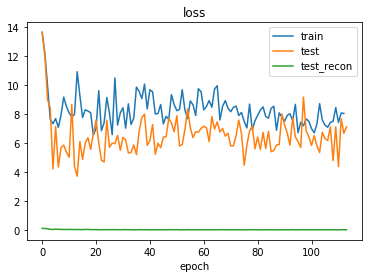

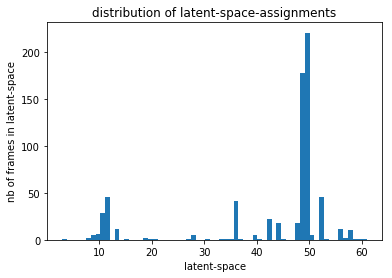

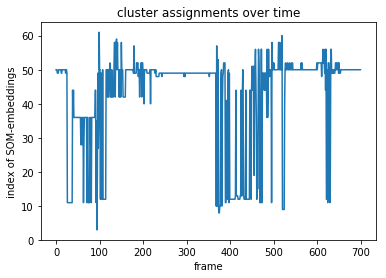

In [127]:
plot_losses(losses)
plot_latent_frame_distribution(res[2], nb_bins=__latent_dim__)
plot_cluster_assignment_over_time(res[2])

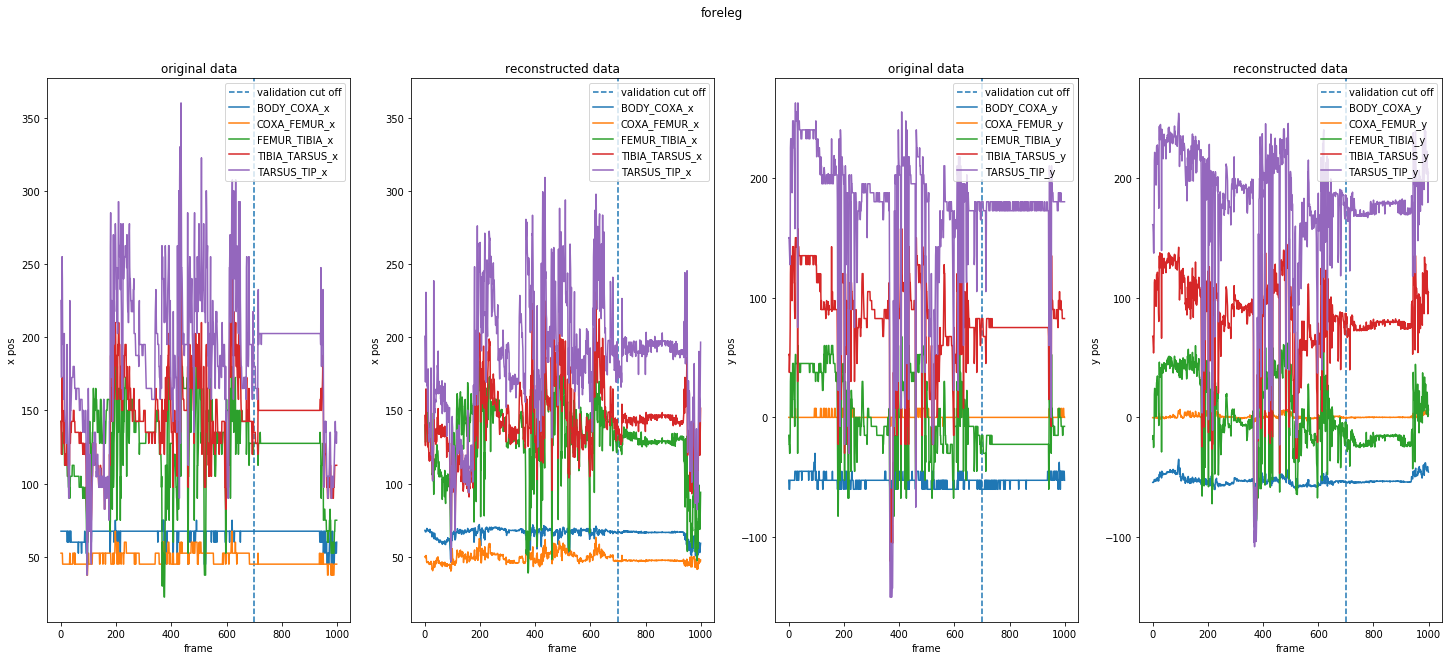

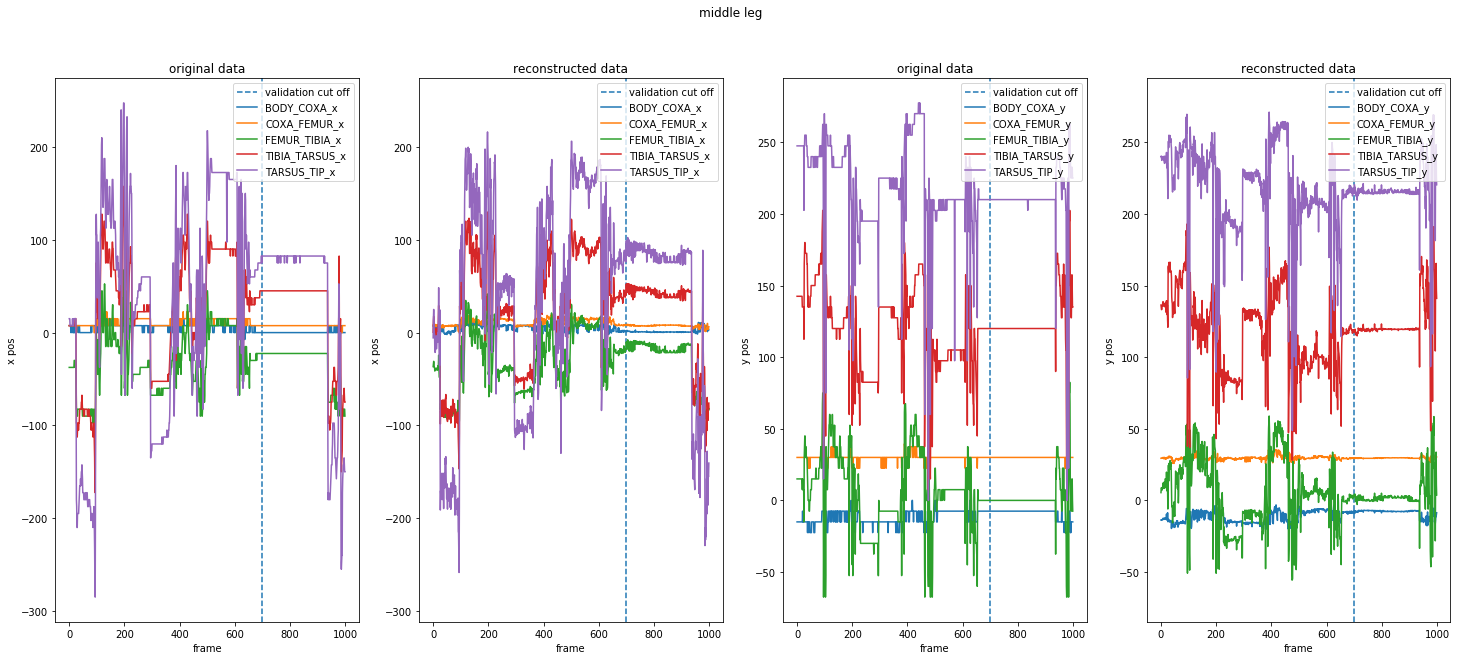

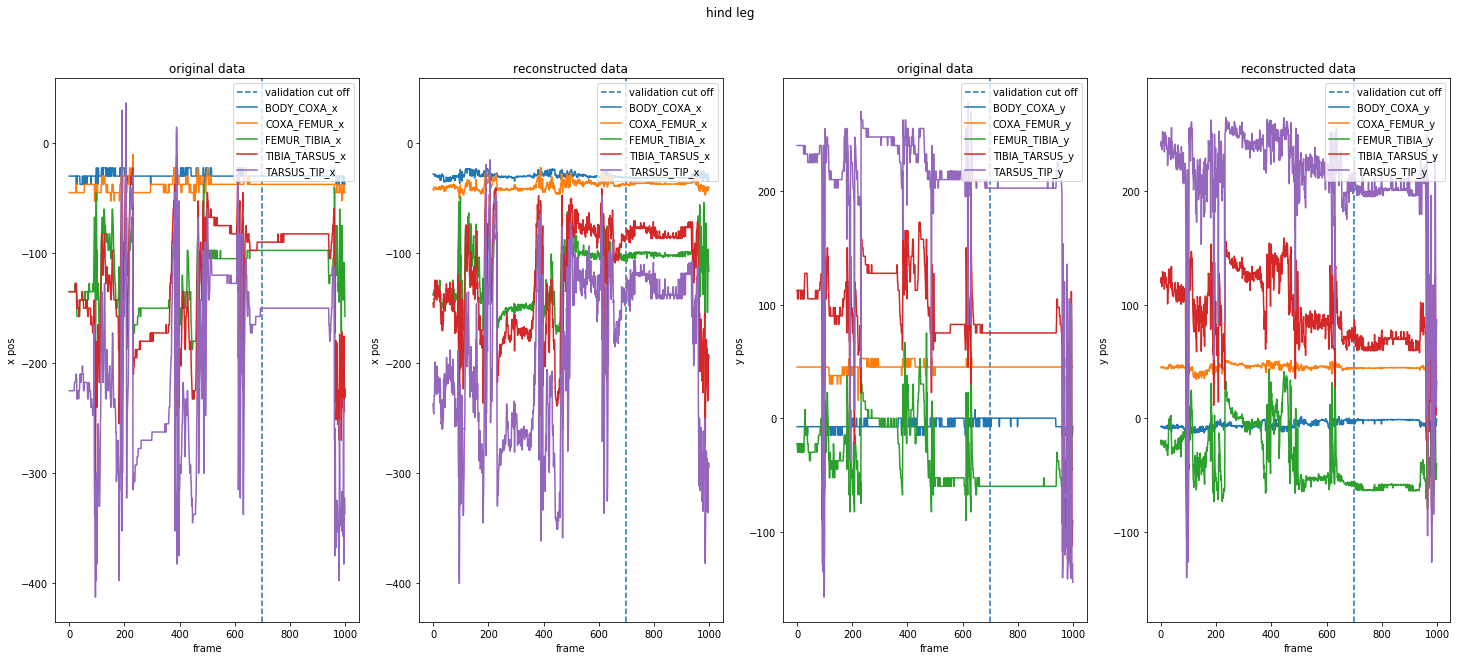

In [128]:
plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                 np.vstack((reconstructed_from_encoding, reconstructed_from_encoding_val)), validation_cut_off=nb_of_data_points)

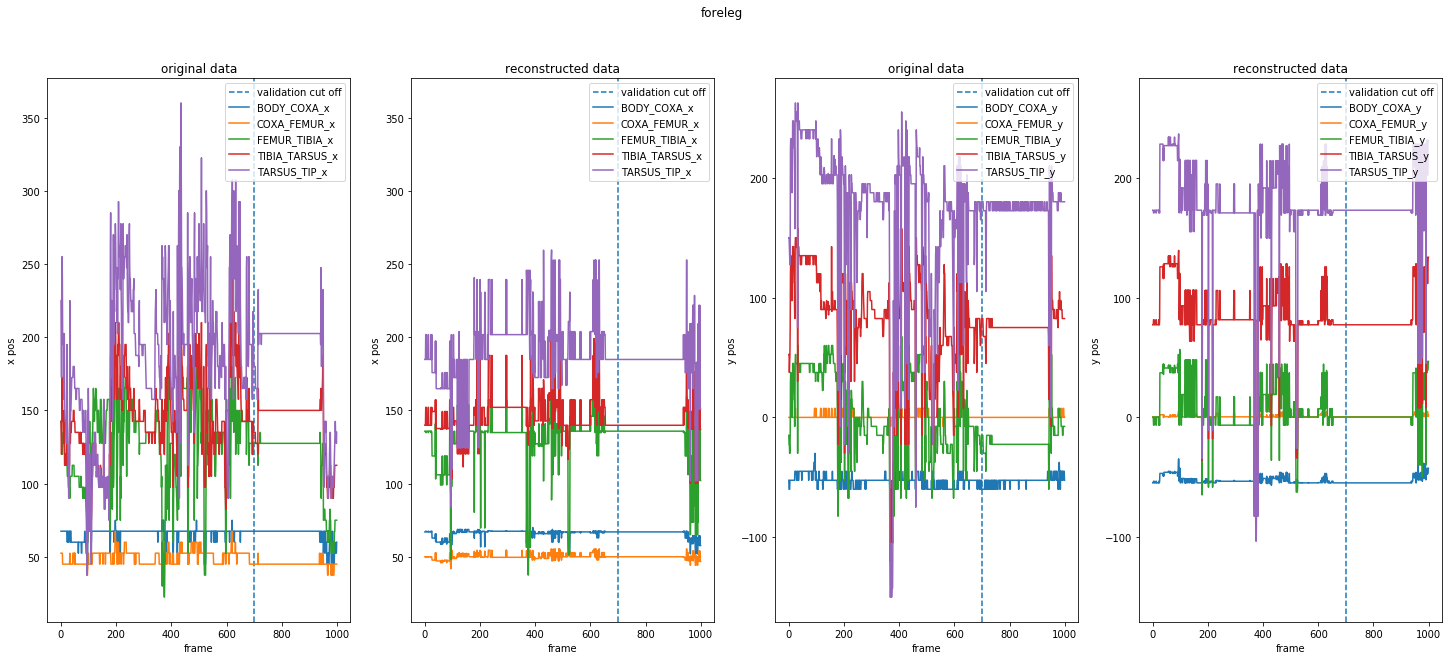

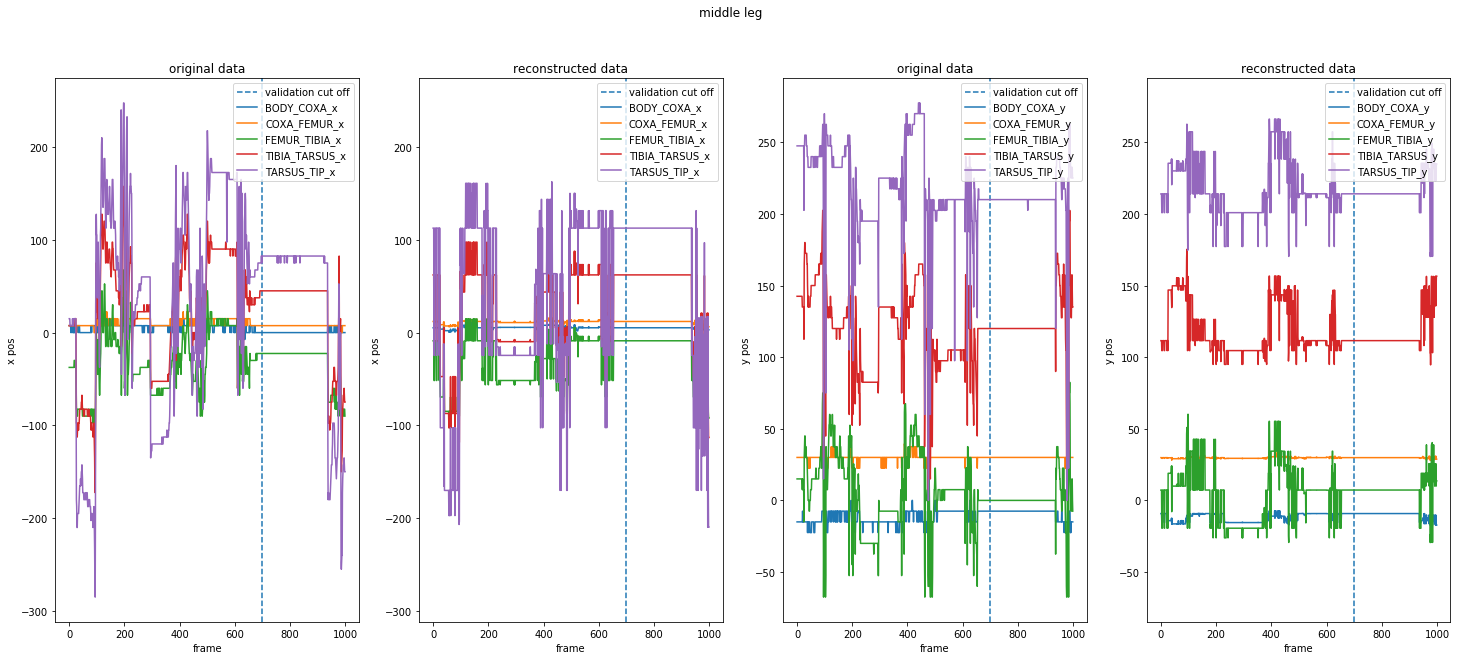

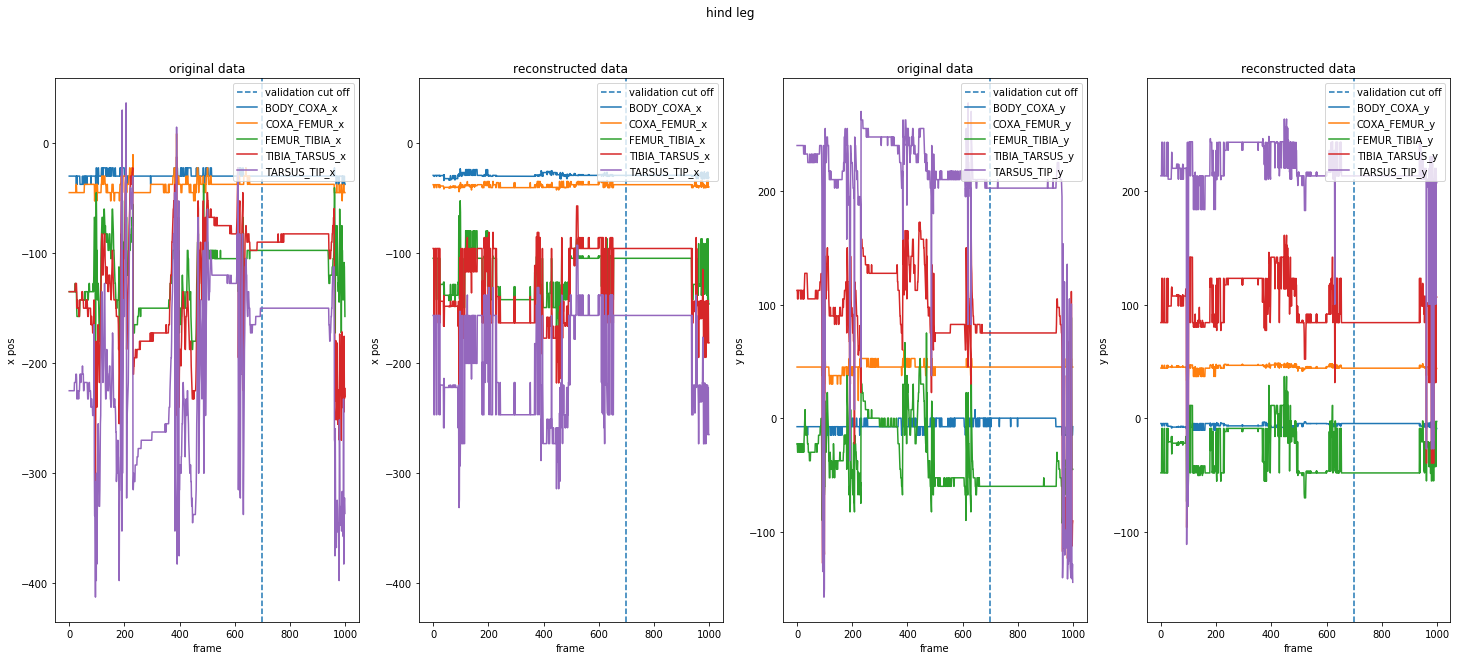

In [129]:
plot_comparing_joint_position_with_reconstructed(joint_positions, 
                                                 np.vstack((reconstructed_from_embedding, reconstructed_from_embedding_val)), validation_cut_off=nb_of_data_points)

In [130]:
((joint_positions[:len(res[3])][:,:,:2] - reconstructed_from_encoding) ** 2).mean()
((joint_positions[:len(res[3])][:,:,:2] - reconstructed_from_embedding) ** 2).mean()

587.942284589333

In [131]:
stop

NameError: name 'stop' is not defined

## cool gifs

```
# use this to display a gif inside the notebook, no idea why a function doesn't work
# this is a hack to display the gif inside the notebook
os.system('cp {0} {0}.png'.format(path))
display.Image(filename=f"{path}.png")
``` 

In [132]:
def reverse_pos_pipeline(x, normalisation_term=joint_norm_factor, to_2d=True):
    # TODO add reshaping and other steps here as well
    _x = add_third_dimension(x) + normalisation_term 
    if to_2d:
        return _x[:,:,:2]
    else:
        return _x

In [150]:
__FRAME_ACTIVE_COLOUR__ = (255, 0, 0)
__FRAME_BAR_MARKER__ = (0, 255, 255)
__N_FRAMES__ = 1000

def create_gif_of_sequence(sequence):
    # TODO this is a bit shitty...
    gif_file_path = _get_and_check_file_path_((sequence[0], sequence[-1]))
                                              
    frame_paths =  [(get_frame_path(i), i) for i in sequence]
    last_frame_id = frame_paths[0][1] - 1
    
    # TODO add a line for each frame
    # TODO mark the current one red, rest in blue
    
    image_width = cv2.imread(frame_paths[0][0]).shape[1]
    
    lines_pos = (np.array(sequence) / __N_FRAMES__ * image_width).astype(np.int).tolist()
    
    frames = []
    for i, (frame_path, frame_id) in enumerate(frame_paths):
        # adding fr nb to image
        image = cv2.imread(frame_path)  
        if last_frame_id + 1 != frame_id:
            color = (0, 255, 255)
        else:
            color = (255, 255, 255)

        last_frame_id = frame_id

        image = cv2.putText(img=np.copy(image), text=str(frame_id), org=(0, image.shape[0] // 2),fontFace=2, fontScale=3, color=color, thickness=2)
        
        for line_idx, l in enumerate(lines_pos):
            if line_idx == i:
                cv2.line(image, (l, 0), (l, 10), __FRAME_ACTIVE_COLOUR__, 2) 
            else:
                cv2.line(image, (l, 0), (l, 10), __FRAME_BAR_MARKER__, 1) 
        
        frames += [image]
                                              
    _save_frames_(gif_file_path, frames, format='mp4')
    
    return gif_file_path


In [151]:
def flatten(listOfLists):
    return reduce(list.__add__, listOfLists, [])
    
    
def group_by_cluster(data):
    """Returns the lengths of sequences.
    Example: AABAAAA -> [[0, 1], [2], [3, 4, 5], [6, 7]]
    
    """
    sequences = []
    cur_embedding_idx = 0
    cur_seq = [0]
    for i in range(len(data))[1:]:
        if data[i] == data[cur_embedding_idx]:
            cur_seq += [i]
        else:
            sequences += [(data[cur_embedding_idx], cur_seq)]
            cur_embedding_idx = i
            cur_seq = [i]
            
    sequences += [(data[cur_embedding_idx], cur_seq)]
            
    return {embedding_id: [el[1] for el in emb_frames] for embedding_id, emb_frames in groupby(sorted(sequences, key=lambda x: x[0]), key=lambda x: x[0])}


def cluster_videos(cluster_assignments, max_clusters=10):
    paths = sorted([flatten(sequences) for cluster_id, sequences in group_by_cluster(cluster_assignments).items()], key=len, reverse=True)
    paths = [create_gif_of_sequence(s) for s in paths[:max_clusters]]
    return paths 


def get_frame_path(frame_id, path=POSE_FRAME_PATH, camera_id=CAMERA_OF_INTEREST):
    return path.format(camera_id=camera_id, frame_id=frame_id)

def _get_and_check_file_path_(args, template=SEQUENCE_GIF_PATH):
    gif_file_path = template.format(begin_frame=args[0], end_frame=args[-1])
    pathlib.Path(gif_file_path).parent.mkdir(parents=True, exist_ok=True)
    
    return gif_file_path
    
    
def _save_frames_(file_path, frames, format='GIF', **kwargs):
    """
    If format==GIF then fps has to be None, duration should be ~10/60
    If format==mp4 then duration has to be None, fps should be TODO
    """
    if format == 'GIF':
        _kwargs = {'duration': 10/60}
    elif format == 'mp4':
        _kwargs = {'fps': 24}
        
    imageio.mimsave(file_path, frames, format=format, **{**_kwargs, **kwargs})


def _add_frame_and_embedding_id_(frame, emb_id, frame_id):
    frame = cv2.putText(img=np.copy(frame), text=f"cluster_id: {emb_id:0>3}", org=(0, frame.shape[0] // 2), fontFace=1, fontScale=2, color=(255, 255, 255), thickness=2)
    frame = cv2.putText(img=np.copy(frame), text=f"frame_id: {frame_id:0>4}", org=(0, (frame.shape[0] // 2) + 24),fontFace=1, fontScale=2, color=(255, 255, 255), thickness=2)
    return frame


def create_gifs_for_clusters(cluster_assignments, up_to_n_clusters=10):
    """
    Args:
        cluster_assignments: list of assignments for each frame
    Returns:
        file paths of the created gifs
    """
    sequences = sorted(group_by_cluster(cluster_assignments), key=len, reverse=True)

    return [create_gif_of_sequence(s) for s in sequences[:up_to_n_clusters]]

In [152]:
def comparision_video_of_reconstruction(xs, embeddings, file_path=None):
    """Creates a video (saved as a gif) with the embedding overlay, displayed as an int.
    
    Args:
        xs: [<pos data>] list of pos data, of shape: [frames, limb, dimensions] (can be just one, but in an array)
            will plot all of them, the colors get lighter
        embeddings: [<embeddings_id>]    
            assumed to be in sequence with `get_frame_path` function.
        file_path: <str>, default: SEQUENCE_GIF_PATH  
            file path used to get 
    Returns:
        <str>                            the file path under which the gif was saved
    """
    gif_file_path = _get_and_check_file_path_(('full-video-x_x-hat', 'with-embeddings')) + '.mp4'
    
    cluster_ids = np.unique(embeddings)
    cluster_colours = dict(zip(cluster_ids, 
                               (np.array(sns.color_palette(n_colors=len(cluster_ids))) * 255).astype(np.int)))
    
    image_width = cv2.imread(get_frame_path(0)).shape[1]
    lines_pos = (np.array(range(__N_FRAMES__)) * 1 / image_width).astype(np.int)
    
    def pipeline(frame, frame_id, embedding_id):
        # kinda ugly... note that some variables are from the upper "frame"
        f = _add_frame_and_embedding_id_(frame, embedding_id, frame_id)
        
        for x_i, x in enumerate(xs):
            f = plot_drosophila_2d(x[frame_id].astype(np.int), 
                                   img=f,
                                   colors=lighten_int_colors(skeleton.colors, 
                                                             amount=np.linspace(0, 0.5, len(xs))[x_i]))
                
                
        # marking the embedding id on the side
        cv2.line(f, (0, embedding_id), (10, embedding_id), (0, 255, 0), 2)
        
        
        for line_idx, l in enumerate(lines_pos):
            if line_idx == frame_id:
                cv2.line(f, (l, 0), (l, 10), __FRAME_ACTIVE_COLOUR__, 2) 
            else:
                cv2.line(f, (l, 0), (l, 10), __FRAME_BAR_MARKER__, 1) 
        
        return f
        
    frames =  [pipeline(cv2.imread(get_frame_path(i)), i, emb_id) for i, emb_id in enumerate(embeddings)]
    _save_frames_(gif_file_path, frames, format='mp4')
    
    return gif_file_path

In [153]:
cluster_vids = cluster_videos(res[2])

In [159]:
display_video(cluster_vids[0])

In [ ]:
idx = 0 
os.system('cp {0} {0}.png'.format(cluster_vids[idx]))
display.Image(filename="{}.png".format(cluster_vids[idx]))

In [143]:
_p = comparision_video_of_reconstruction((joint_positions_raw[:,:,:2], 
                  reverse_pos_pipeline(reconstructed_from_encoding),
                  reverse_pos_pipeline(reconstructed_from_embedding)), 
                 embeddings=res[2])

# shitty way of displaying them here...
#os.system('cp {0} {0}.png'.format(_p))
#display.Image(filename="{}.png".format(_p))

TypeError: _open() got an unexpected keyword argument 'duration'

In [ ]:
file

In [ ]:
os.system('cp {0} {0}.png'.format(_p))
display.Image(filename="{}.png".format(_p))

In [ ]:
_p

In [ ]:
full_clip = video_with_embedding(res[2])

In [ ]:
os.system('cp {0} {0}.png'.format(full_clip))
display.Image(filename="{}.png".format(full_clip))